In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr


In [3]:

# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix, returns

def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")


In [73]:

#stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stockList = ['MSFT', 'BAC', 'PG','AA']
stocks = [stock + '' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=3500)

meanReturns, covMatrix, returns = get_data(stocks, startDate, endDate)



In [80]:
print(covMatrix)
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

mc_sims = 30 # number of simulations
T = 30#timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio


day_zero = np.array([initialPortfolio for i in range(mc_sims) ]).astype(np.float64).reshape(1,mc_sims)
portfolio_sims = np.vstack((day_zero,portfolio_sims))
portResults = pd.Series(portfolio_sims[-1,:])


VaR = initialPortfolio - mcVaR(portResults, alpha=0.01)


Symbols      MSFT       BAC        PG        AA
Symbols                                        
MSFT     0.000263  0.000135  0.000078  0.000142
BAC      0.000135  0.000375  0.000072  0.000296
PG       0.000078  0.000072  0.000126  0.000062
AA       0.000142  0.000296  0.000062  0.000879


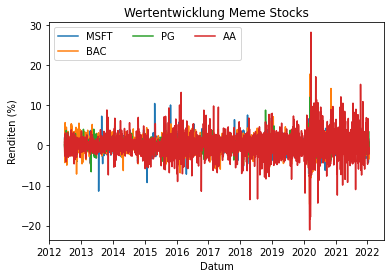

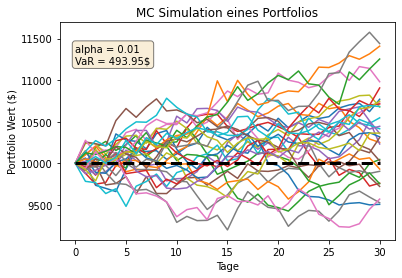

VaR $493.95


In [83]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plot returns
plt.plot(returns*100)
plt.ylabel('Renditen (%)')
plt.xlabel('Datum')
plt.title('Wertentwicklung Meme Stocks')
plt.legend([i for i in stockList], ncol=3)
plt.show()

#plot mc
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Wert ($)')
plt.xlabel('Tage')
plt.title('MC Simulation eines Portfolios')
plt.text(0,11200,'alpha = 0.01 \nVaR = {}$'.format(round(VaR,2)),bbox=props)
plt.plot([0, 30], [10000, 10000],color='black',
         linestyle="dashed",linewidth=3)
plt.show()


# CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
#print('CVaR ${}'.format(round(CVaR,2)))
